# 1. import pytorch library

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 2. 載入CIFAR-10 dataset



In [ ]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
batch_size = 64

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 170498071/170498071 [00:05<00:00, 30592604.96it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# 3. 定義model與loss function

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # output: 64 x 16 x 16
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # output: 192 x 8 x 8
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # output: 256 x 4 x 4
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# 4. Training model

In [ ]:
learning_rate = 0.001
num_epochs = 10

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AlexNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [ ]:
def train():
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')


        val_loss, val_accuracy = validate()
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


In [ ]:
def validate():
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

In [ ]:
train()

Epoch [1/10], Training Loss: 1.7973, Training Accuracy: 31.40%
Epoch [1/10], Validation Loss: 1.5817, Validation Accuracy: 39.64%
Epoch [2/10], Training Loss: 1.3676, Training Accuracy: 49.39%
Epoch [2/10], Validation Loss: 1.2626, Validation Accuracy: 54.09%
Epoch [3/10], Training Loss: 1.1686, Training Accuracy: 57.83%
Epoch [3/10], Validation Loss: 1.1123, Validation Accuracy: 60.02%
Epoch [4/10], Training Loss: 1.0475, Training Accuracy: 62.88%
Epoch [4/10], Validation Loss: 1.0055, Validation Accuracy: 64.18%
Epoch [5/10], Training Loss: 0.9510, Training Accuracy: 66.46%
Epoch [5/10], Validation Loss: 0.9125, Validation Accuracy: 68.06%
Epoch [6/10], Training Loss: 0.8682, Training Accuracy: 69.51%
Epoch [6/10], Validation Loss: 0.9203, Validation Accuracy: 68.58%
Epoch [7/10], Training Loss: 0.8151, Training Accuracy: 71.57%
Epoch [7/10], Validation Loss: 0.8284, Validation Accuracy: 71.78%
Epoch [8/10], Training Loss: 0.7681, Training Accuracy: 73.23%
Epoch [8/10], Validation Lo

# 5. Evaluate model

In [ ]:
def test():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the 10000 test images: {100 * correct / total:.2f}%')


In [ ]:
test()

Accuracy of the model on the 10000 test images: 73.58%


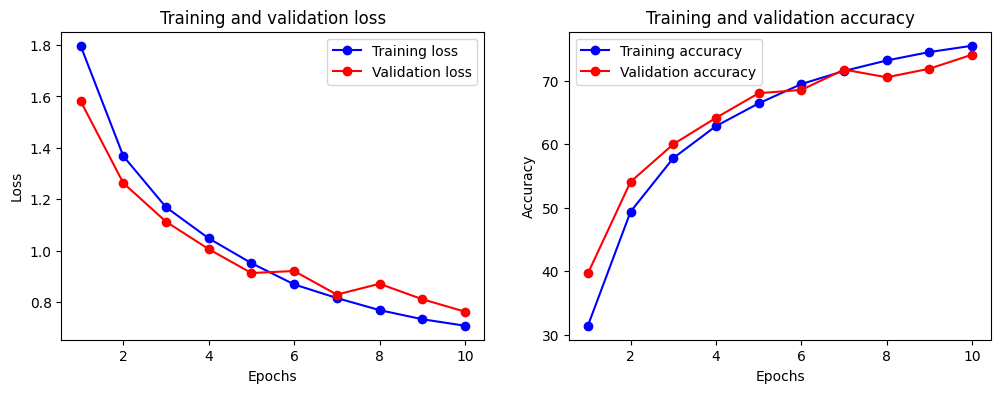

In [ ]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))


plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 參考網站
- [Alexnet paper](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

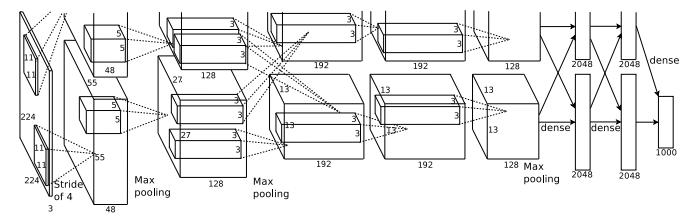